<a href="https://colab.research.google.com/github/sashkoangelov/Sample-difficulty-estimation-through-action-scores-for-various-NLP-tasks/blob/main/RoBERTa_twitter_sentimentAnalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Imports

In [2]:
pip install transformers

In [3]:
pip install tensorflow

In [4]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
import nltk
nltk.download('stopwords')
import re
import string
from nltk.corpus import stopwords
import torch
import seaborn as sns
import transformers
import json
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import RobertaTokenizer, RobertaModel, RobertaForSequenceClassification, AdamW
from sklearn.metrics import accuracy_score, classification_report
from torch.utils.tensorboard import SummaryWriter
import logging
logging.basicConfig(level=logging.ERROR)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


## Ensuring GPU usage

In [5]:
from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'

# Data loading

In [6]:
train = pd.read_csv('/content/drive/MyDrive/Thesis/Datasets/twitter_training.csv', names=["id","entity","sentiment","tweet"])
test = pd.read_csv('/content/drive/MyDrive/Thesis/Datasets/twitter_validation.csv', names=["id","entity","sentiment","tweet"])

In [7]:
train.head()

,id,entity,sentiment,tweet
0,2401,Borderlands,Positive,im getting on borderlands and i will murder yo...
1,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
2,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
3,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
4,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...


## Class distribution

<ipython-input-8-92c3139df543>:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x='sentiment', data=train, palette='dark')


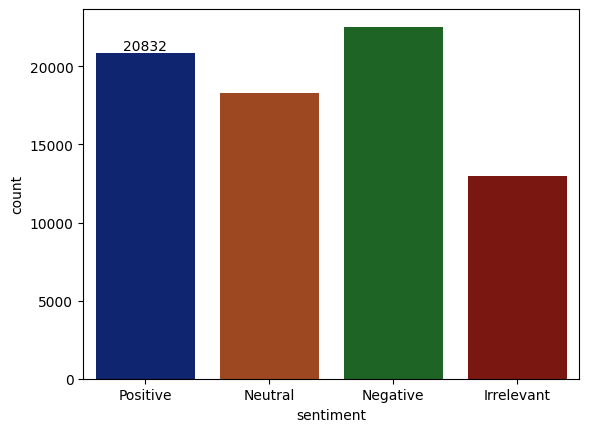

In [8]:
ax = sns.countplot(x='sentiment', data=train, palette='dark')
ax.bar_label(ax.containers[0], label_type='edge')
plt.show()

## Cleaning and encoding

###Converting from object datatype to strings and category. Needed for regex operations

In [9]:
train["sentiment"] = train["sentiment"].astype("category")
train["tweet"] = train["tweet"].apply(str)

test["sentiment"] = test["sentiment"].astype("category")
test["tweet"] = test["tweet"].apply(str)

###Data cleaning

In [10]:
def cleaning(tweet):

    # Removing all the @ mentions from the tweets
    tweet = re.sub(r"@[A-Za-z0-9]+","", tweet)

    # Removing the links from the tweets
    tweet = re.sub(r"https?://[A-Za-z0-9./]+","", tweet)

    # Removing unnecessary characters like emojis from the tweets
    tweet = re.sub(r"[^ A-Za-z0-9.!?']","", tweet)

    # Removing any extra whitespaces
    tweet = re.sub(r" +"," ", tweet)

    # Removing punctuation
    tweet = tweet.translate(str.maketrans('', '', string.punctuation))

    # Removing numbers
    tweet = re.sub(r'\d+', '', tweet)

    # Removing stopwords
    stop_words = set(stopwords.words('english'))
    tweet = ' '.join(word for word in tweet.split() if word not in stop_words)

    return tweet

In [11]:
train['clean_tweet'] = [cleaning(tweet) for tweet in train['tweet']]
test['clean_tweet'] = [cleaning(tweet) for tweet in test['tweet']]

###Only keeping the necessary columns: *sentiment* and *clean_tweets* and removing the unnecessary columns: *tweet*, *id* and *entity*

---




In [12]:
train.drop(['tweet','id','entity'], axis = 1, inplace = True)
test.drop(['tweet','id','entity'], axis = 1, inplace = True)

### Saving the test data

In [13]:
import os

def save_test_data(test_data, output_dir):
    output_file = os.path.join(output_dir, 'test_data.csv')
    test_data.to_csv(output_file, index=False)
    print(f'Test data saved to: {output_file}')

save_test_data(test, '/content/drive/MyDrive/Thesis/Datasets')

Test data saved to: /content/drive/MyDrive/Thesis/Datasets/test_data.csv


### Word clouds per class

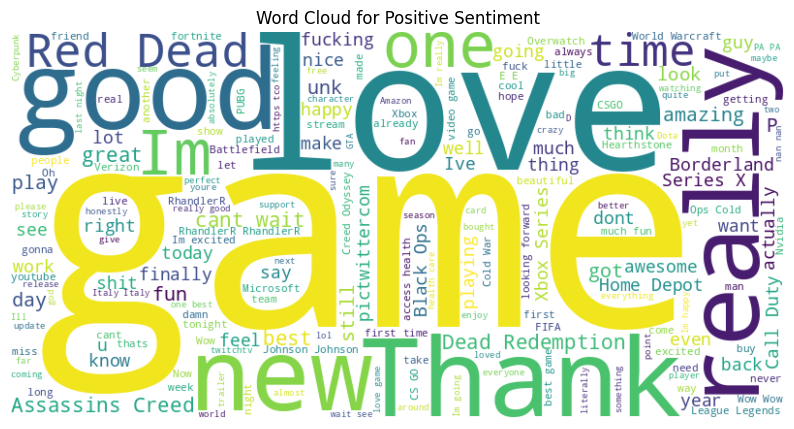

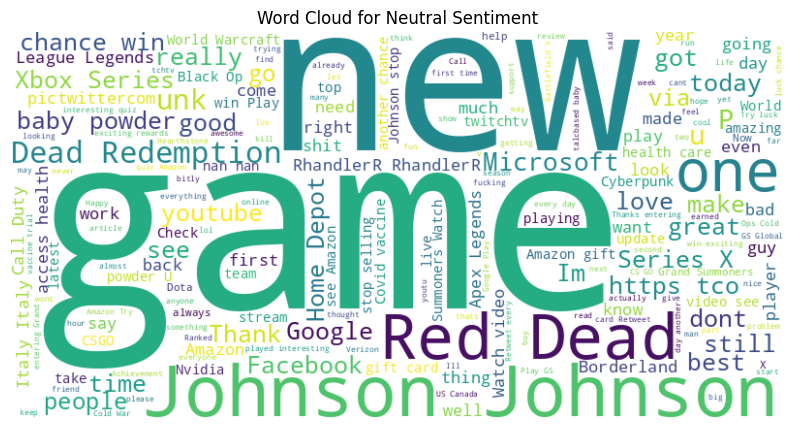

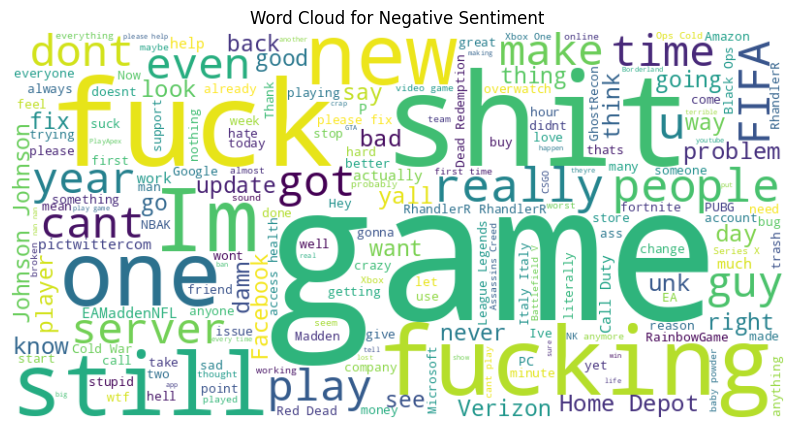

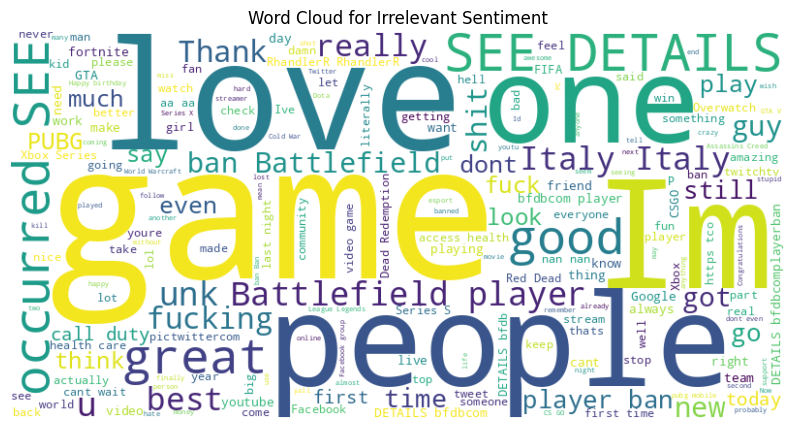

In [14]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

def generate_word_clouds(sentiment_texts):
    # Create a word cloud for each sentiment class
    for sentiment, texts in sentiment_texts.items():
        # Filter out missing values and convert to strings
        texts = [str(text) for text in texts if pd.notna(text)]

        # Join all texts for the sentiment class into a single string
        text = ' '.join(texts)

        # Generate word cloud
        wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

        # Plot word cloud
        plt.figure(figsize=(10, 6))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.title(f'Word Cloud for {sentiment} Sentiment')
        plt.axis('off')
        plt.show()


# Preprocess data and organize into sentiment classes
def preprocess_data(df):
    sentiment_texts = {'Positive': [], 'Neutral': [], 'Negative': [], 'Irrelevant': []}
    for index, row in df.iterrows():
        sentiment = row['sentiment']
        text = row['clean_tweet']
        sentiment_texts[sentiment].append(text)
    return sentiment_texts

# Example usage
import pandas as pd

# Preprocess the data
sentiment_texts = preprocess_data(train)

# Generate word clouds
generate_word_clouds(sentiment_texts)

###Turning the categorial values of 'sentiment' into numerical using an encoder

In [15]:
label_encoder = LabelEncoder()
label_encoder.fit(train["sentiment"])

train["sentiment"]= label_encoder.transform(train["sentiment"])
test["sentiment"]= label_encoder.transform(test["sentiment"])

#Tokenize

In [16]:
# Define hyperparameters
MAX_LEN = 256
BATCH_SIZE = 16
LR = 2e-5
EPOCHS = 2
LEARNING_RATE = 1e-05

In [17]:
# Define dataset class
class CustomDataset(Dataset):
    def __init__(self, tweets, labels, tokenizer, max_len):
        self.tweets = tweets
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.tweets)

    def __getitem__(self, idx):
        tweet = str(self.tweets[idx])
        label = self.labels[idx]

        encoding = self.tokenizer.encode_plus(
            tweet,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )

        return {
            'tweet_text': tweet,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'label': torch.tensor(label, dtype=torch.long)
        }

In [18]:
# Instantiate the tokenizer and model
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
model = RobertaForSequenceClassification.from_pretrained('roberta-base', num_labels=len(label_encoder.classes_))

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Define training function
def train_fn(model, train_loader, optimizer, device):
    model.train()
    total_loss = 0

    for batch in train_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        optimizer.zero_grad()

        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        total_loss += loss.item()

        loss.backward()
        optimizer.step()

    return total_loss / len(train_loader)

# Define evaluation function
def evaluate_fn(model, val_loader, device):
    model.eval()
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for batch in val_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            outputs = model(input_ids, attention_mask=attention_mask)
            _, predicted = torch.max(outputs.logits, 1)

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())

    return all_labels, all_preds

# Create DataLoader
train_dataset = CustomDataset(
    tweets=train['clean_tweet'].values,
    labels=train['sentiment'].values,
    tokenizer=tokenizer,
    max_len=MAX_LEN
)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)




/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [19]:
def train_fn_1(model, train_loader, optimizer, loss_function, device):
    model.train()
    losses = []
    total_loss = 0.0

    for batch in train_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        outputs = model(input_ids, attention_mask=attention_mask)

        individual_losses = loss_function(outputs.logits, labels)

        loss = individual_losses.mean()  # Calculate the mean loss for backpropagation.
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * input_ids.size(0)  # Accumulate the total loss.

        for i in range(len(input_ids)):
            sample_loss = {
                'tweet_text': batch['tweet_text'][i],
                'loss': individual_losses[i].item()  # Storing individual loss for each sample.
            }
            losses.append(sample_loss)

    # Calculate the average training loss for the epoch.
    train_loss = total_loss / len(train_loader.dataset)

    return train_loss, losses

## Training loop

In [ ]:
# Dictionary to track the losses
all_losses = {}

optimizer = AdamW(model.parameters(), lr=LR)
loss_function = torch.nn.CrossEntropyLoss(reduction='none')

for epoch in range(EPOCHS):
    print(f'Epoch {epoch + 1}/{EPOCHS}')
    train_loss, epoch_losses = train_fn_1(model, train_loader, optimizer, loss_function, device)

    # Update the all_losses dictionary
    for loss_entry in epoch_losses:
        tweet_text = loss_entry['tweet_text']
        loss_value = loss_entry['loss']

        if tweet_text not in all_losses:
            all_losses[tweet_text] = [loss_value]  # Start a new list for this sample
        else:
            all_losses[tweet_text].append(loss_value)  # Append the new loss to the existing list for this sample

    print(f'Training Loss: {train_loss}')


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/2


In [ ]:
all_losses[1:10]

In [ ]:
highest_loss_sample = max(all_losses, key=lambda x: x['loss'])
lowest_loss_sample = min(all_losses, key=lambda x: x['loss'])

print("Sample with Highest Loss:")
print(f"Text: {highest_loss_sample['tweet_text']}")
print(f"Loss: {highest_loss_sample['loss']}")

print("\nSample with Lowest Loss:")
print(f"Text: {lowest_loss_sample['tweet_text']}")
print(f"Loss: {lowest_loss_sample['loss']}")

In [ ]:
#for epoch in range(EPOCHS):
    #print(f'Epoch {epoch + 1}/{EPOCHS}')
    #train_loss = train_fn(model, train_loader, optimizer, device)
    #print(f'Training Loss: {train_loss}')

## Evaluate on test set

In [ ]:
test_dataset = CustomDataset(
    tweets=test['clean_tweet'].values,
    labels=test['sentiment'].values,
    tokenizer=tokenizer,
    max_len=MAX_LEN
)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

true_labels, pred_labels = evaluate_fn(model, test_loader, device)

# Calculate accuracy and other metrics
accuracy = accuracy_score(true_labels, pred_labels)
print(f'Accuracy: {accuracy}')

print(classification_report(true_labels, pred_labels, target_names=label_encoder.classes_))

#Save model, tokenizer and label encoder

In [ ]:
import os

# Specify the directory where you want to save the model
output_dir = '/content/drive/MyDrive/Thesis/Models'

# Save the model and tokenizer
model.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

# Save label encoder using joblib or pickle
import joblib
joblib.dump(label_encoder, os.path.join(output_dir, 'label_encoder.pkl'))

# Inference

## Load model, tokenizer and label encoder

In [ ]:
from transformers import RobertaTokenizer, RobertaForSequenceClassification
import torch
import joblib
import os

output_dir = '/content/drive/MyDrive/Thesis/Models'

# Load the tokenizer
tokenizer = RobertaTokenizer.from_pretrained(output_dir)

# Load the model
model = RobertaForSequenceClassification.from_pretrained(output_dir)

# Load the label encoder.
# Used to reverse map the numerical values to categorical predictions
label_encoder = joblib.load(os.path.join(output_dir, 'label_encoder.pkl'))

## Get sentiment function

In [ ]:
def get_sentiment(input_text, model, tokenizer, label_encoder, device):
    # Tokenize input text
    inputs = tokenizer(input_text, return_tensors='pt', max_length=256, truncation=True, padding='max_length')

    # Move input tensors to the same device as the model
    input_ids = inputs['input_ids'].to(device)
    attention_mask = inputs['attention_mask'].to(device)

    # Pass input through model
    with torch.no_grad():
        outputs = model(input_ids, attention_mask=attention_mask)

    # Apply softmax to get probabilities
    probs = torch.softmax(outputs.logits, dim=1).squeeze()

    # Map probabilities to sentiment labels
    sentiment_probs = {label_encoder.classes_[i]: probs[i].item() for i in range(len(label_encoder.classes_))}

    return sentiment_probs

## Pie chart

In [ ]:
def pie_chart(sentiment_probs):
    # Define custom colors for each sentiment
    colors = ['gray', 'red', 'yellow', 'green']

    # Create a pie chart
    plt.figure(figsize=(8, 6))
    plt.pie(sentiment_probs.values(), labels=None, colors=colors, autopct='%1.1f%%', startangle=140)
    plt.title("Sentiment Probabilities")
    plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

    # Add a legend with custom colors
    plt.legend(sentiment_probs.keys(), loc="best", bbox_to_anchor=(1, 0.5), title="Sentiments", fancybox=True, shadow=True)

    plt.tight_layout()
    plt.show()

## Inference

In [ ]:
import torch

# Define the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

input_text = "Just finished my shit morning routine and heading to my awful work. The weather is neither too hot nor too cold, just perfect. Looking forward to a boring day ahead!"
sentiment_probs = get_sentiment(input_text, model.to(device), tokenizer, label_encoder, device)

print("Sentiment Probabilities:")
for sentiment, prob in sentiment_probs.items():
    print(f"{sentiment}: {prob:.4f}")

pie_chart(sentiment_probs)